In [1]:
# import========================================================================
import pandas as pd
import numpy as np
import re
import string
import pickle
from time import time
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
from datetime import datetime
import datetime as dt

In [6]:
# read table into dataframe=====================================================
print("Loading dataset...")
t0 = time()
with open('03_tokentext_cn.pickle', 'rb') as handle:
    trade_war_tokentext_cn = pickle.load(handle)
dataset = trade_war_tokentext_cn
print("done in %0.3fs." % (time() - t0))

Loading dataset...
done in 0.137s.


In [7]:
# parameters====================================================================
n_features = 2000
# n_components = 20
n_top_words = 10
stop_words = ['贸易战','是','要','有','能','来','贸易','贸易','中国',
              '美国','战','么','特朗普','川普','开始','新闻时时报','新闻',
              '明镜','播音','视频','现在','北京','年月','认识','年月日','时事',
              '重要','宣布','正式','全面','真正','小时','讲话','准备']

In [8]:
# functions=====================================================================
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [9]:
# tokenization and modeling=====================================================

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.4,
                                   max_features=n_features,
                                   stop_words=stop_words)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(dataset)
print("done in %0.3fs." % (time() - t0))
# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_features=%d..."
      % n_features)
t0 = time()
nmf = NMF(n_components=6, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)
print('--------------------------------------')



Extracting tf-idf features for NMF...
done in 1.778s.
Fitting the NMF model (Frobenius norm) with tf-idf features, n_features=2000...
done in 3.705s.

Topics in NMF model (Frobenius norm):
Topic #0: 经济 影响 问题 全球 世界 市场 政府 股市 政治 人民
Topic #1: 开打 反击 股市 今日 世界 报复 大陆 开战 香港 台湾
Topic #2: 关税 商品 加征 进口 产品 征收 大豆 总统 出口 清单
Topic #3: 神韵 器官 功活 法轮 巡演 退出 大陆 共产党 共产党网 巡回演出
Topic #4: 升级 人民币 争端 和解 重大 汇率 商品 金融战 持续 征税
Topic #5: 习近平 王岐山 郭文贵 李克强 主席 刘鹤 谈判 博鳌 习近 金正恩

--------------------------------------


In [10]:
# get two metrices

doc_topic = nmf.transform(tfidf)
topic_word = nmf.components_

df_doc_topic = pd.DataFrame(doc_topic)
df_topic_word = pd.DataFrame(topic_word)

In [11]:
# load df

with open('02_df_cn.pickle', 'rb') as handle:
    df = pickle.load(handle)
    
df = df.reset_index(drop=True)

In [12]:
# figure out each document's topic, filter out gabage

def assign_topic(indx):
    if doc_topic[indx].sum() == 0:
        return -1
    else:
        return np.argmax(doc_topic[indx])

In [13]:
# assign topics and filter out gabage

df['topic'] = [assign_topic(i) for i in df.index]
df = df[df['topic']!=-1]
df = df[df['topic']!=3]

In [14]:
# map topic names
mapp = {0:'Economy & Issue',
        1:'Fight the War',
        2:'Tariff',
        4:'Currency',
        5:'Chinese Leaders'}

def map_name(num):
    return mapp[num]

df['topic_name'] = df['topic'].apply(map_name)

In [15]:
# pickling

with open('04_df_cn.pickle', 'wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

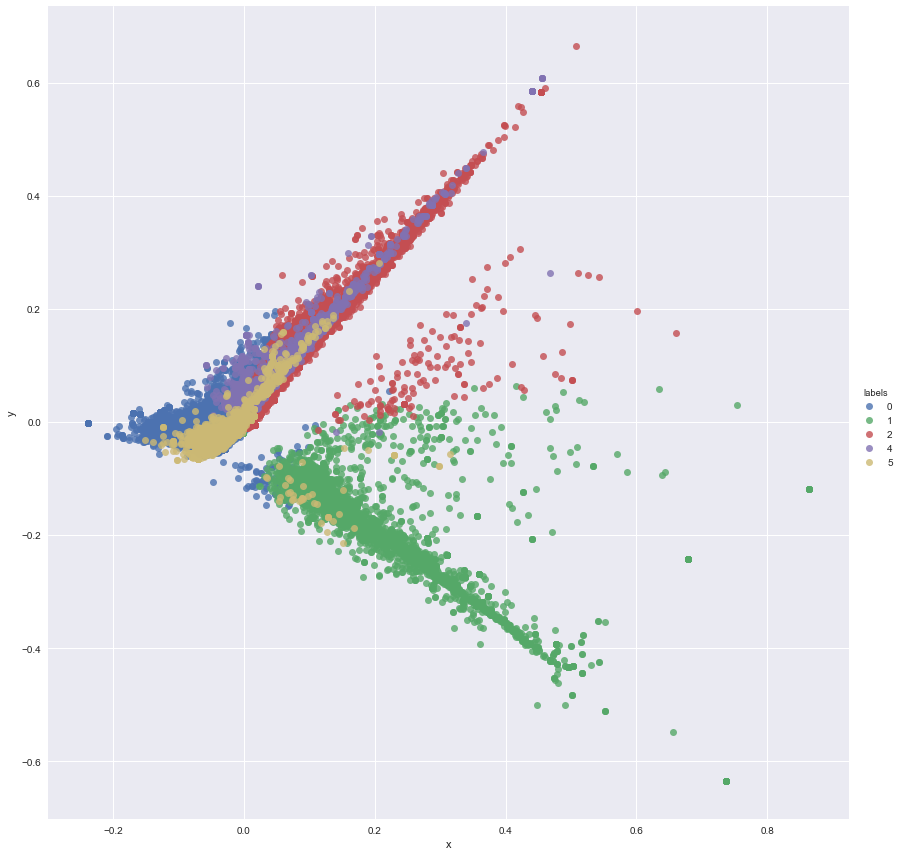

In [16]:
temp = df[['username','topic']]
temp = (temp.join(pd.DataFrame(tfidf.toarray()))
                        .drop('username',axis=1))

#y = temp['topic']
X = temp.drop('topic',axis=1)

from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
PCAxy = pca.fit_transform(X)

# plt.figure(figsize = (16,12))
# plt.scatter(x[:,0], x[:,1], c=y)
# plt.show()

# plot data with seaborn

data = pd.DataFrame()
data['x']=PCAxy.T[0]
data['y']=PCAxy.T[1]
data['labels']=list(temp['topic'])

facet = sns.lmplot(data=data, x='x', y='y', hue='labels', 
                   fit_reg=False, legend=True, legend_out=True, size=12, aspect=1)

In [14]:
# generate df for visualization

df_viz = df.copy()
df_viz['datetime'] = df_viz['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M"))
df_viz.to_csv('viz_cn.csv')

In [15]:
# get unique user names for location scraping

users = df['username'].unique()
with open('users_cn.pickle', 'wb') as handle:
    pickle.dump(users, handle, protocol=pickle.HIGHEST_PROTOCOL)